# TorchGAN


In [1]:
try:
    import torchgan

    print(f"Existing TorchGAN {torchgan.__version__} installation found")
except ImportError:
    import subprocess
    import sys

    subprocess.check_call([sys.executable, "-m", "pip", "install", "torchgan"])
    import torchgan

    print(f"Installed TorchGAN {torchgan.__version__}")

Installed TorchGAN v0.1.0


## IMPORTS

In [2]:
# General Imports
import os
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML

# Pytorch and Torchvision Imports
import torch
import torch.nn as nn
import torchvision
from torch.optim import Adam
import torch.nn as nn
import torch.utils.data as data
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Torchgan Imports
import torchgan
from torchgan.models import *
from torchgan.losses import *
from torchgan.trainer import Trainer

In [3]:
# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print("Random Seed: ", manualSeed)

Random Seed:  999


## DATA LOADING AND PREPROCESSING

In [4]:
dataset = dsets.MNIST(
    root="./mnist",
    train=True,
    transform=transforms.Compose(
        [
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,), std=(0.5,)),
        ]
    ),
    download=True,
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [6]:
dataloader = data.DataLoader(dataset, batch_size=64, shuffle=True)

## NETWORK ARCHITECTURE : DCGAN

In [9]:
dcgan_network = {
    "generator": {
        "name": DCGANGenerator,
        "args": {
            "encoding_dims": 100,
            "out_channels": 1,
            "step_channels": 32,
            "nonlinearity": nn.LeakyReLU(0.2),
            "last_nonlinearity": nn.Tanh(),
        },
        "optimizer": {"name": Adam, "args": {"lr": 0.0001, "betas": (0.5, 0.999)}},
    },
    "discriminator": {
        "name": DCGANDiscriminator,
        "args": {
            "in_channels": 1,
            "step_channels": 32,
            "nonlinearity": nn.LeakyReLU(0.2),
            "last_nonlinearity": nn.LeakyReLU(0.2),
        },
        "optimizer": {"name": Adam, "args": {"lr": 0.0003, "betas": (0.5, 0.999)}},
    },
}

## LOSS FUNCTIONS

In [10]:
minimax_losses = [MinimaxGeneratorLoss(), MinimaxDiscriminatorLoss()]
wgangp_losses = [
    WassersteinGeneratorLoss(),
    WassersteinDiscriminatorLoss(),
    WassersteinGradientPenalty(),
]
lsgan_losses = [LeastSquaresGeneratorLoss(), LeastSquaresDiscriminatorLoss()]

## VISUALIZE THE TRAINING DATA

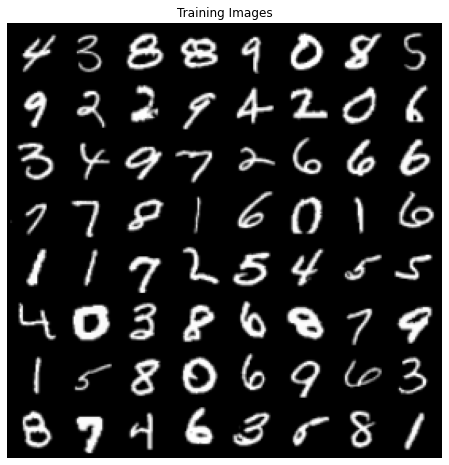

In [11]:
# Plot some of the training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(), (1, 2, 0)
    )
)
plt.show()

## TRAINING THE NETWORK

In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    # Use deterministic cudnn algorithms
    torch.backends.cudnn.deterministic = True
    epochs = 10
else:
    device = torch.device("cpu")
    epochs = 5

print("Device: {}".format(device))
print("Epochs: {}".format(epochs))

Device: cuda:0
Epochs: 10


In [13]:
trainer = Trainer(
    dcgan_network, lsgan_losses, sample_size=64, epochs=epochs, device=device
)

In [14]:
trainer(dataloader)

Saving Model at './model/gan0.model'
Epoch 1 Summary
Epoch time duration : 36.13282370567322
generator Mean Gradients : 4.178919348524797
discriminator Mean Gradients : 17.636168489984957
Mean Running Discriminator Loss : 0.03637755199023751
Mean Running Generator Loss : 0.580514599074687
Generating and Saving Images to ./images/epoch1_generator.png



/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


Saving Model at './model/gan1.model'
Epoch 2 Summary
Epoch time duration : 34.58739471435547
generator Mean Gradients : 2.35659116726507
discriminator Mean Gradients : 13.111183945693043
Mean Running Discriminator Loss : 0.022615389773378403
Mean Running Generator Loss : 0.5565911444074818
Generating and Saving Images to ./images/epoch2_generator.png

Saving Model at './model/gan2.model'
Epoch 3 Summary
Epoch time duration : 34.246182918548584
generator Mean Gradients : 1.9153242615367432
discriminator Mean Gradients : 19.970778975246855
Mean Running Discriminator Loss : 0.02694148009048223
Mean Running Generator Loss : 0.5409054287259851
Generating and Saving Images to ./images/epoch3_generator.png

Saving Model at './model/gan3.model'
Epoch 4 Summary
Epoch time duration : 34.317893266677856
generator Mean Gradients : 2.110373742036319
discriminator Mean Gradients : 22.98682989306482
Mean Running Discriminator Loss : 0.027773461370941884
Mean Running Generator Loss : 0.526124507867927

## VISUALIZING THE SAMPLES

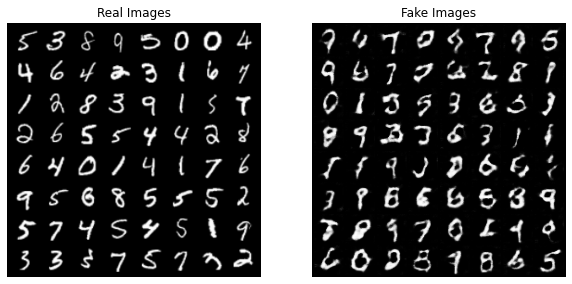

In [15]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            real_batch[0].to(device)[:64], padding=5, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(plt.imread("{}/epoch{}_generator.png".format(trainer.recon, trainer.epochs)))
plt.show()

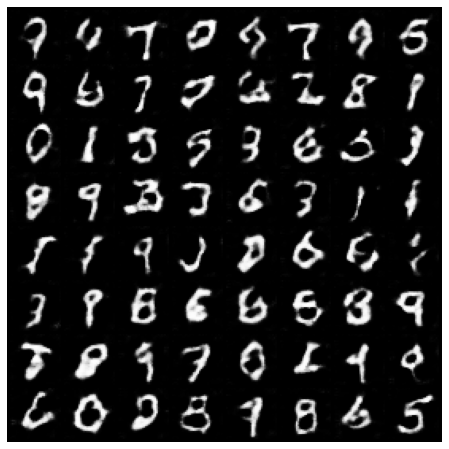

In [16]:
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [
    [plt.imshow(plt.imread("{}/epoch{}_generator.png".format(trainer.recon, i)))]
    for i in range(1, trainer.epochs + 1)
]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# Play the animation
HTML(ani.to_jshtml())

## TRAINING CONDITIONAL GAN MODELS (Optional)

In [17]:
cgan_network = {
    "generator": {
        "name": ConditionalGANGenerator,
        "args": {
            "encoding_dims": 100,
            "num_classes": 10,  # MNIST digits range from 0 to 9
            "out_channels": 1,
            "step_channels": 32,
            "nonlinearity": nn.LeakyReLU(0.2),
            "last_nonlinearity": nn.Tanh(),
        },
        "optimizer": {"name": Adam, "args": {"lr": 0.0001, "betas": (0.5, 0.999)}},
    },
    "discriminator": {
        "name": ConditionalGANDiscriminator,
        "args": {
            "num_classes": 10,
            "in_channels": 1,
            "step_channels": 32,
            "nonlinearity": nn.LeakyReLU(0.2),
            "last_nonlinearity": nn.Tanh(),
        },
        "optimizer": {"name": Adam, "args": {"lr": 0.0003, "betas": (0.5, 0.999)}},
    },
}

## LOSS FUNCTIONS

In [18]:
trainer_cgan = Trainer(
    cgan_network, lsgan_losses, sample_size=64, epochs=epochs, device=device
)

In [19]:
trainer_cgan(dataloader)

Saving Model at './model/gan0.model'
Epoch 1 Summary
Epoch time duration : 37.635541915893555
generator Mean Gradients : 2.747266825040666
discriminator Mean Gradients : 8.517133421550575
Mean Running Discriminator Loss : 0.032069889120390216
Mean Running Generator Loss : 0.5093011474415564
Generating and Saving Images to ./images/epoch1_generator.png



/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


Saving Model at './model/gan1.model'
Epoch 2 Summary
Epoch time duration : 37.25580811500549
generator Mean Gradients : 2.0408567549160397
discriminator Mean Gradients : 9.563900053279752
Mean Running Discriminator Loss : 0.04342664559835942
Mean Running Generator Loss : 0.49175010591609225
Generating and Saving Images to ./images/epoch2_generator.png

Saving Model at './model/gan2.model'
Epoch 3 Summary
Epoch time duration : 39.097787857055664
generator Mean Gradients : 2.4301061164453066
discriminator Mean Gradients : 12.401059208203934
Mean Running Discriminator Loss : 0.07566294825495855
Mean Running Generator Loss : 0.44232701890230725
Generating and Saving Images to ./images/epoch3_generator.png

Saving Model at './model/gan3.model'
Epoch 4 Summary
Epoch time duration : 37.50443410873413
generator Mean Gradients : 3.303064894511589
discriminator Mean Gradients : 14.577693429154978
Mean Running Discriminator Loss : 0.08418395582839464
Mean Running Generator Loss : 0.42643802889728

## VISUALIZING THE SAMPLES

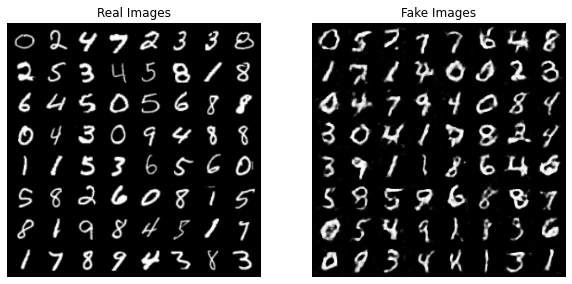

In [20]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            real_batch[0].to(device)[:64], padding=5, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(plt.imread("{}/epoch{}_generator.png".format(trainer.recon, trainer.epochs)))
plt.show()

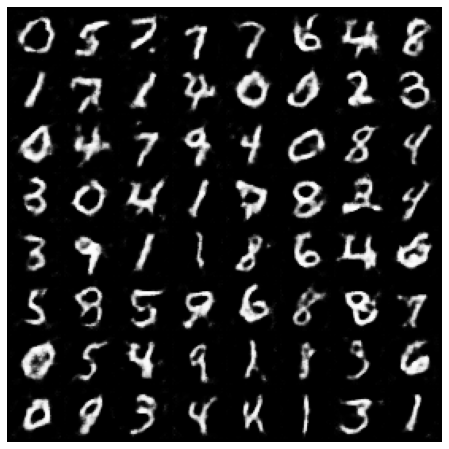

In [21]:
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [
    [plt.imshow(plt.imread("{}/epoch{}_generator.png".format(trainer.recon, i)))]
    for i in range(1, trainer.epochs + 1)
]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# Play the animation
HTML(ani.to_jshtml())